# Assignment 3

## Importing ctypes and Shared Library

In [2]:
import ctypes
import os
import psutil
import numpy as np
from pynq.ps import Clocks as psclk
from datetime import datetime

In [1]:
def recur_fibo(n):
   if n <= 1:
       return n
   else:
       return(recur_fibo(n-1) + recur_fibo(n-2))
   
def func_runner(idx, cpu_num):
    # Get the current process
    p = psutil.Process(os.getpid())
    
    # Set the CPU affinity to the specified CPU
    p.cpu_affinity([cpu_num])

    # print(f"Running on CPU {cpu_num}")
    result = recur_fibo(idx)
    # print(f"Fibonacci Sequence up to {idx}: {result}")
    return 0

In [5]:
_assignment3lib = ctypes.CDLL('./Assignment3/assignment3.so')

In [ ]:
def testRunner(fib):

    # Get the 'before' time using the python time module
    beforeCountDatetime = np.datetime64(datetime.now())
    # Initialize the cycle counter
    _assignment3lib.initCounters(1,1)
    # Get the 'before' cycle count
    beforeCount = _assignment3lib.getCycleCount()

    # Run the recur_fibo function on a CPU1
    func_runner(fib, 1)

    # Get the 'after' cycle count
    afterCount = _assignment3lib.getCycleCount()

    # Get the 'after' time count using the python time module
    afterCountDatetime = np.datetime64(datetime.now())
    
    # Get the cycle count and the amount of time used
    # Keeping units in microseconds for accuracy: 10^-6
    deltaCount = (afterCount - beforeCount)/psclk.cpu_mhz
    deltaDatetime = afterCountDatetime - beforeCountDatetime
    deltaDatetimeus = int(deltaDatetime / np.timedelta64(1, 'us'))

    return deltaCount, deltaDatetimeus


In [ ]:
testRunnerList = []

# Gather data
for num_vars in range(1, 20):
    count_results = []
    datetime_results = []
    for _ in range(1, 6):  # number of trials
        curDeltaCount, curDeltaCountDatetime = testRunner(num_vars)
        count_results.append(curDeltaCount)
        datetime_results.append(curDeltaCountDatetime)
    testRunnerList.append((num_vars, count_results, datetime_results))

In [17]:
# Organize data for plotting
means_count = []
errors_count = []
means_datetime = []
errors_datetime = []
inputs = []

for entry in testRunnerList:
    num_vars, count_results, datetime_results = entry
    inputs.append(num_vars)

    # For curDeltaCount
    mean_count = np.mean(count_results)
    error_count = np.std(count_results, ddof=1) / np.sqrt(len(count_results))

    # For curDeltaCountDatetime
    mean_datetime = np.mean(datetime_results)
    error_datetime = np.std(datetime_results, ddof=1) / np.sqrt(len(datetime_results))

    means_count.append(mean_count)
    errors_count.append(error_count)
    means_datetime.append(mean_datetime)
    errors_datetime.append(error_datetime)

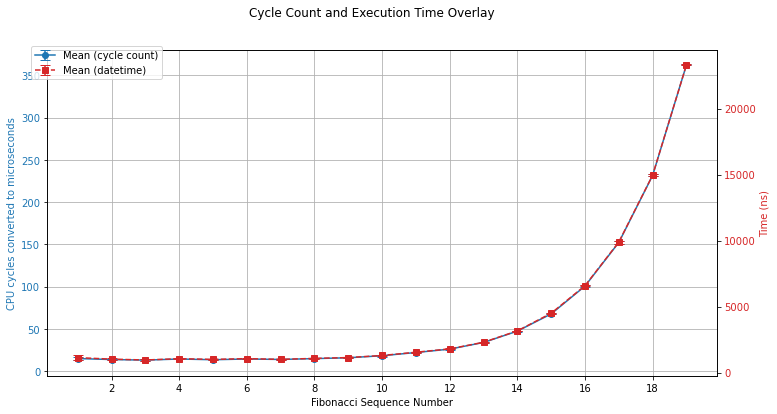

In [21]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the first dataset (Cycle Count)
ax1.errorbar(inputs, means_count, yerr=errors_count, fmt='o-', capsize=5, label='Mean (cycle count)', color='tab:blue')
ax1.set_xlabel('Fibonacci Sequence Number')
ax1.set_ylabel('CPU cycles converted to microseconds', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))  # Whole number X-axis ticks
ax1.grid(True)

# Create a second Y-axis that shares the same X-axis
ax2 = ax1.twinx()
ax2.errorbar(inputs, means_datetime, yerr=errors_datetime, fmt='s--', capsize=5, label='Mean (datetime)', color='tab:red')
ax2.set_ylabel('Time (ns)', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Title and legend
fig.suptitle('Cycle Count and Execution Time Overlay')
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
plt.show()

In [24]:
import time
print(psclk.cpu_mhz)
psclk.set_pl_clk(0, clk_mhz=500)
time.sleep(1)
print(psclk.cpu_mhz)
print(psclk.fclk0_mhz)

650.0
650.0
500.0
